# o'reillyのネゴザメ言語モデルの本
長短期記憶ニューラルネットワーク（LSTM）

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インストール](#インストール)
  - [インポート](#インポート)
- [RNNの問題、勾配爆発・消失](#RNNの問題、勾配爆発・消失)
  - [勾配爆発対策の勾配クリッピング](#勾配爆発対策の勾配クリッピング)
  - [勾配消失対策はLSTM自体が特性による。](#勾配消失対策はLSTM自体が特性による。)
- [長短期記憶ニューラルネットワーク（LSTM）](#長短期記憶ニューラルネットワーク（LSTM）)
  - [先ずは、LSTMレイヤの実装](#先ずは、LSTMレイヤの実装)
  - [T個の時系列データの処理を行うTime LSTM実装](#T個の時系列データの処理を行うTime_LSTM実装)
  - [LSTMを使用した言語モデル、SimpleLstmlmの実装](#LSTMを使用した言語モデル、SimpleLstmlmの実装)
  - [LSTMを使用した言語モデル、BetterLstmlmの実装](#LSTMを使用した言語モデル、BetterLstmlmの実装)
  - [LSTMを使用した言語モデルで次単語予測の文書生成](#LSTMを使用した言語モデルで次単語予測の文書生成)

## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch06
- https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/ch07
- [長短期記憶ニューラルネットワーク（LSTM） - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E9%95%B7%E7%9F%AD%E6%9C%9F%E8%A8%98%E6%86%B6%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88LSTM%EF%BC%89)

## 環境準備

### インストール

In [ ]:
!pip install numpy
!pip install matplotlib

### インポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定

In [ ]:
from nekozame.common.functions import sigmoid
from nekozame.common.functions import softmax

## RNNの問題、勾配爆発・消失

In [ ]:
flag = True

In [ ]:
# バッチサイズ
N = 2
# 時間サイズ
T = 20
# 隠れ状態ベクトルの次元を指定
H = 3

dh = np.ones((N, H))

np.random.seed(3)

print(flag)

if (flag):
    # 勾配爆発
    Wh = np.random.randn(H, H)
else:
    # 勾配消失
    Wh = np.random.randn(H, H) * 0.5
    
# 勾配爆発 or 消失切替
flag = not flag

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    # L2ノルムはユークリッド距離
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

#### 勾配爆発対策の勾配クリッピング
パラメタの勾配のL2ノルムが制限されるようにする。

##### 関数

In [ ]:
def clip_grads(grads, max_norm):
    
    # L2ノルムを計算
    total_norm = 0
    
    for grad in grads:
        total_norm += np.sum(grad ** 2)
        
    total_norm = np.sqrt(total_norm)

    # 勾配クリッピング
    if max_norm <= total_norm : # rate < 1:
        # レートを計算（0除算防止）
        rate = max_norm / (total_norm + 1e-6)
        # 勾配のL2ノルムを制限
        for grad in grads: grad *= rate

##### 検証

In [ ]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10

print('before:', dW1.flatten())
clip_grads(grads = [dW1, dW2], max_norm = 5.0)
print('after:', dW1.flatten())

#### 勾配消失対策はLSTM自体が特性による。
[長短期記憶ニューラルネットワーク（LSTM） - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E9%95%B7%E7%9F%AD%E6%9C%9F%E8%A8%98%E6%86%B6%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88LSTM%EF%BC%89)
- (+)ノードでは勾配消失は起きない。
- (*)ノードでは勾配消失は起き難い（アダマール積）
- 記憶セルを計算する忘却ゲートベクトルを計算するアフィン変換ノードの重みは勾配消失が起き難い。

## 長短期記憶ニューラルネットワーク（LSTM）

### 先ずは、LSTMレイヤの実装

#### 定義

In [ ]:
class _LSTM:
    # 初期化メソッドの定義
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # パラメータ
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 勾配
        self.cache = None
    
    # 順伝播メソッドの定義
    def forward(self, x, h_prev, c_prev):
        # パラメータと変数の形状に関する値を取得
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        # 結合したパラメータによる重み付き和の計算
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        # 各ゲートの重み付き和を取得
        f = A[:, :H]      # forgetゲート
        g = A[:, H:2*H]   # 記憶セル
        i = A[:, 2*H:3*H] # inputゲート
        o = A[:, 3*H:]    # outputゲート
        
        # ゲート値に変換
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        # 出力を計算
        c_next = f * c_prev + g * i  # 記憶セル
        h_next = o * np.tanh(c_next) # 出力データ
        
        # 逆伝播の計算用に変数を保存
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    # 逆伝播メソッドの定義
    def backward(self, dh_next, dc_next):
        # 変数を取得
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        # 計算用に活性化記憶セルを計算
        tanh_c_next = np.tanh(c_next)
        
        # 現レイヤの記憶セルの勾配を計算
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        # 前レイヤの記憶セルの勾配を計算
        dc_prev = ds * f
        
        # 活性化後のゲートの勾配を計算
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        # 活性化前のゲートの勾配を計算
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        
        # ゲートの勾配を結合
        dA = np.hstack((df, dg, di, do))
        
        # パラメータの勾配を計算
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        # パラメータの勾配を格納
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        # 入力の勾配を計算
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

#### 実行

##### データの準備

In [ ]:
# バッチサイズ
N = 5
# Embedベクトルの次元を指定
D = 15
# 隠れ状態ベクトルの次元を指定
H = 10

# 入力データに対応する重みを生成
Wx = np.random.randn(D, H * 4)
# 1つ前の出力に対応する重みを生成
Wh = np.random.randn(H, H * 4)
# バイアスを生成
b = np.zeros(H * 4)

# 順伝播の入力を生成
x = np.random.rand(N, D) * 2 # Embedレイヤの出力
h_prev = np.random.rand(N, H) * 2 # 1つ前のLSTMレイヤの出力
c_prev = np.random.rand(N, H) * 2 # 1つ前のLSTMレイヤの記憶セル

# 逆伝播の入力を生成
dh_next = np.random.rand(N, H) * 2 # LSTMレイヤの出力
dc_next = np.random.rand(N, H) * 2 # LSTMレイヤの記憶セル

##### 順伝播と逆伝播

In [ ]:
# LSTMレイヤのインスタンスを作成
layer = _LSTM(Wx, Wh, b)

# 順伝播を計算
h_next, c_next = layer.forward(x, h_prev, c_prev)
print(np.round(h_next, 2))
print(np.round(c_next, 2))

# 逆伝播を計算
dx, dh_prev, dc_prev = layer.backward(dh_next, dc_next)
print(np.round(dh_prev, 2))
print(np.round(dc_prev, 2))

### T個の時系列データの処理を行うTime_LSTM実装

#### 定義

In [ ]:
# Time LSTMレイヤの実装
class _TimeLSTM:
    # 初期化メソッドの定義
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b] # パラメータ
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 勾配
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
    
    # 順伝播メソッドの定義
    def forward(self, xs):
        # パラメータを取得
        Wx, Wh, b = self.params
        
        # 形状に関する値を取得
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        # 受け皿を初期化
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        # 入力を初期化
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        # LSTMレイヤの処理
        for t in range(T):
            # LSTMレイヤのインスタンスを作成
            layer = _LSTM(*self.params)
            
            # 順伝播を計算
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            
            # 出力データを格納
            hs[:, t, :] = self.h
            self.layers.append(layer)
        
        return hs
    
    # 逆伝播メソッドの定義
    def backward(self, dhs):
        # パラメータを取得
        Wx, Wh, b = self.params
        
        # 形状に関する値を取得
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        # 出力の受け皿を初期化
        dxs = np.empty((N, T, D), dtype='f')
        
        # 入力を初期化
        dh, dc = 0, 0
        
        # LSTMレイヤの処理
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            # t番目のLSTMレイヤのを取得
            layer = self.layers[t]
            
            # 逆伝播の計算
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            
            # 入力データの勾配を格納
            dxs[:, t, :] = dx
            
            # 各パラメータの勾配を加算
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        # パラメータの勾配を格納
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        # 隠れ状態の勾配を保存
        self.dh = dh
        return dxs
    
    # ネットワークの継続メソッド？
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    # ネットワークの切断メソッド？
    def reset_state(self):
        self.h, self.c = None, None

#### 実行

##### データの準備

In [ ]:
# バッチサイズ
N = 5
# 時間サイズ
T = 7

# Embedベクトルの次元を指定
D = 12
# 隠れ状態ベクトルの次元を指定
H = 10

# 入力データに対応する重みを生成
Wx = np.random.randn(D, H * 4)
# 1つ前の出力に対応する重みを生成
Wh = np.random.randn(H, H * 4)
# バイアスを生成
b = np.zeros(H * 4)

# 順伝播の入力を生成
xs = np.random.rand(N, T, D) * 10
print(np.round(xs[:, 0, :], 2)) # 0時刻の入力

# 受け皿を初期化
dxs = np.empty((N, T, D))

# 逆伝播の入力を生成
dhs = np.ones_like(np.empty((N, T, H)))

##### 順伝播と逆伝播

In [ ]:
# Time LSTMレイヤのインスタンスを作成
layer = _TimeLSTM(Wx, Wh, b)

# 順伝播を計算
hs = layer.forward(xs)
print(np.round(hs[:, 0, :], 2)) # 0時刻の出力

# 逆伝播を計算
dxs = layer.backward(dhs)
print(np.round(dxs[:, 0, :], 2)) # 0時刻の出力

# 重み（の次元
for name, grad in zip(['dWx', 'dWh', 'db'], layer.grads):
    print(name, grad.shape)

### LSTMを使用した言語モデル、SimpleLstmlmの実装
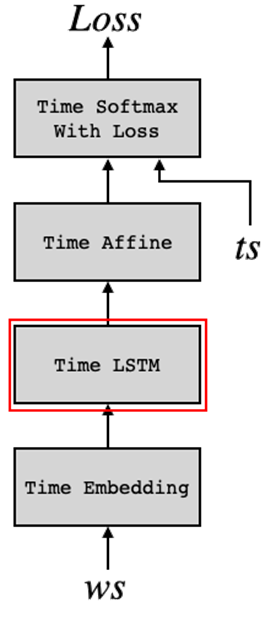

#### 定義

In [ ]:
import pickle

# RNNLMの実装
class SimpleLstmlm:
    # 初期化メソッドの定義
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        # 形状に関する値を取得
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        # パラメータを初期化
        embed_W = (np.random.randn(V, D) / 100).astype('f')
        lstm_Wx = (np.random.randn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (np.random.randn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤを作成
        self.layers = [
            TimeEmbedding(embed_W), 
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True), 
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # パラメータと勾配を書くの
        self.params = [] # パラメータ
        self.grads = []  # 勾配
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    # 推論メソッドの定義
    def predict(self, xs):
        # 各レイヤの順伝播を計算
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    # 順伝播メソッドの定義
    def forward(self, xs, ts):
        # スコアを計算
        score = self.predict(xs)
        
        # 損失を計算
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    # 逆伝播メソッドの定義
    def backward(self, dout=1):
        # 後のレイヤから逆伝播を計算
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    # ネットワークの継続メソッドの定義
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    # 学習済みパラメータの保存メソッドの定義
    def save_params(self, file_name='../work/Lstmlm.pkl'):
        with open(file_name, 'rb') as f:
            # パラメータを保存
            pickle.dump(self.params, f)
    
    # 学習済みパラメータの読み込みメソッドの定義
    def load_params(self, file_name='../work/Lstmlm.pkl'):
        with open(file_name, 'rb') as f:
            # パラメータを読み込む
            self.params = pickle.load(f)

#### 実行

##### データの準備

In [ ]:
from nekozame.dataset import ptb

# コーパスのサイズ
corpus_size = 1000

# 学習データの読み込み
# 929589語から成る文
corpus,      word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _,          _          = ptb.load_data('test')

# コーパスの単語数
vocab_size = len(word_to_id)

# 時系列予測（次単語予測）の
xs = corpus[:-1]  # 教師データ
ts = corpus[1:]   # 教師ラベル

print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

##### 学習と評価

In [ ]:
# ハイパーパラメタの設定

# バッチサイズ
batch_size = 20
# 時間サイズ
time_size = 35

# Embedベクトルの次元を指定
wordvec_size = 100
# 隠れ状態ベクトルの次元を指定
hidden_size = 100

# 学習率
lr = 0.1
# エポック
max_epoch = 1000

###### train_custom_loop

In [ ]:
from nekozame.common.time_layers import *
from nekozame.common.optimizer import SGD

# 学習時に使用する変数
data_size = len(xs)
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# ミニバッチの開始位置を計算
jump = data_size // batch_size # 間隔
offsets = [n * jump for n in range(batch_size)] # インデックス

# 最適化手法のインスタンスを作成
optimizer = SGD(lr)

# モデルの生成
model = SimpleLstmlm(vocab_size, wordvec_size, hidden_size)

# エポックごとに学習
for epoch in range(max_epoch):
    for iter in range(max_iters):
        
        # ミニバッチを取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1 # カウント
        
        # 損失を計算
        loss = model.forward(batch_x, batch_t)
        
        # 勾配を計算
        model.backward()
        
        # パラメータを更新
        optimizer.update(model.params, model.grads)
        
        # 平均損失計算用に加算
        total_loss += loss
        loss_count += 1
    
    # パープレキシティを計算
    ppl = np.exp(total_loss / loss_count)
    print(
        '| eploch ' + str(epoch + 1) + ' | perplexity: ' + str(np.round(ppl, 2))
    )
    ppl_list.append(float(ppl)) # 結果を記録
    total_loss, loss_count = 0, 0 # カウントを初期化

In [ ]:
# グラフの描画
plt.plot(np.arange(1, len(ppl_list) + 1), ppl_list)
plt.title('Simple LSTMLM', fontsize=20)
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.show()

###### train
上記のコードをRnnlmTrainerに置き換えたバージョン

In [ ]:
from nekozame.common.optimizer import SGD
from nekozame.common.trainer import RnnlmTrainer
from nekozame.common.util import eval_perplexity

# 学習時に使用する変数
data_size = len(xs)
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 勾配クリッピングを適用して学習
max_grad = 0.25
            
# モデルの生成
model = SimpleLstmlm(vocab_size, wordvec_size, hidden_size)
trainer = RnnlmTrainer(model, SGD(lr))

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

### LSTMを使用した言語モデル、BetterLstmlmの実装
より良いLSTMLMの実装
- LSTMレイヤの多層化
- Dropoutによる過学習の抑制
- 重みの共有（embed_W[V, D] <-(転置)-> affine_W[D, V]）

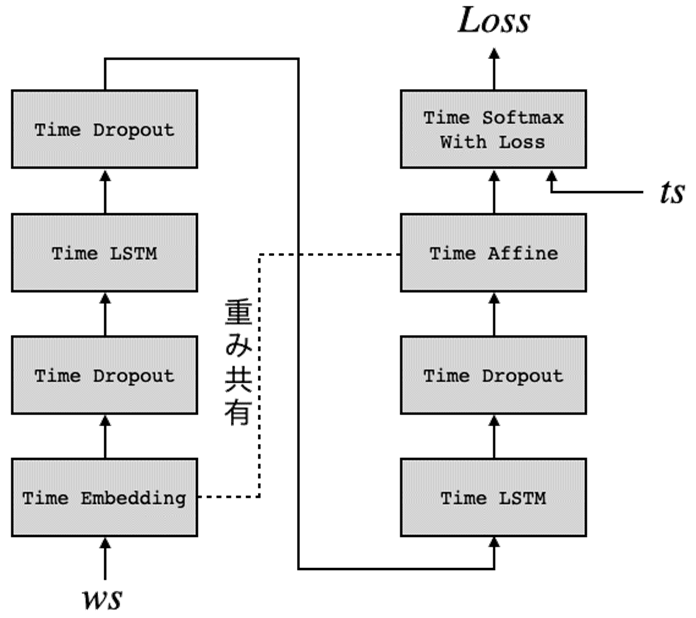

#### 定義

In [ ]:
from nekozame.common.time_layers import *
from nekozame.common.np import *  # import numpy as np
from nekozame.common.base_model import BaseModel

class BetterLstmlm(BaseModel):
    '''
     LSTMレイヤを2層利用し、各層にDropoutを使うモデル
     [1]で提案されたモデルをベースとし、weight tying[2][3]を利用

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

#### 実行

##### データの準備

In [ ]:
# SimpleLstmlmのデータを流用

##### 学習と評価

In [ ]:
# SimpleLstmlmのハイパーパラメタを流用

###### train_custom_loop

In [ ]:
from nekozame.common.optimizer import SGD

# 学習時に使用する変数
data_size = len(xs)
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# ミニバッチの開始位置を計算
jump = data_size // batch_size # 間隔
offsets = [n * jump for n in range(batch_size)] # インデックス

# 最適化手法のインスタンスを作成
optimizer = SGD(lr)

# モデルの生成
model = BetterLstmlm(vocab_size, wordvec_size, hidden_size)

# エポックごとに学習
for epoch in range(max_epoch):
    for iter in range(max_iters):
        
        # ミニバッチを取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1 # カウント
        
        # 損失を計算
        loss = model.forward(batch_x, batch_t)
        
        # 勾配を計算
        model.backward()
        
        # パラメータを更新
        optimizer.update(model.params, model.grads)
        
        # 平均損失計算用に加算
        total_loss += loss
        loss_count += 1
    
    # パープレキシティを計算
    ppl = np.exp(total_loss / loss_count)
    print(
        '| eploch ' + str(epoch + 1) + ' | perplexity: ' + str(np.round(ppl, 2))
    )
    ppl_list.append(float(ppl)) # 結果を記録
    total_loss, loss_count = 0, 0 # カウントを初期化

In [ ]:
# グラフの描画
plt.plot(np.arange(1, len(ppl_list) + 1), ppl_list)
plt.title('Simple LSTMLM', fontsize=20)
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.show()

###### train
上記のコードをRnnlmTrainerに置き換えたバージョン

In [ ]:
from nekozame.common.optimizer import SGD
from nekozame.common.trainer import RnnlmTrainer
from nekozame.common.util import eval_perplexity

# 学習時に使用する変数
data_size = len(xs)
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 勾配クリッピングを適用して学習
max_grad = 0.25
            
# モデルの生成
model = BetterLstmlm(vocab_size, wordvec_size, hidden_size)
trainer = RnnlmTrainer(model, SGD(lr))

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

### LSTMを使用した言語モデルで次単語予測の文書生成

#### 定義

##### SimpleLstmlmGen

In [ ]:
class SimpleLstmlmGen(SimpleLstmlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            # 確率分布 p に従ってサンプリング
            sampled = np.random.choice(len(p), size=1, p=p)
            
            # 前処理された単語をスキップする
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)

##### BetterLstmlmGen

In [ ]:
class BetterLstmlmGen(BetterLstmlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            # 確率分布 p に従ってサンプリング
            sampled = np.random.choice(len(p), size=1, p=p)
            
            # 前処理された単語をスキップする
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

#### 実行

##### SimpleLstmlmGen

In [ ]:
from nekozame.dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = SimpleLstmlmGen()
model.load_params('../work/Lstmlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

##### BetterLstmlmGen

In [ ]:
from nekozame.dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterLstmlmGen()
model.load_params('../work/BetterLstmlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)